In [1]:
import Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
include("../src/TCVAR.jl")

Main.TCVAR

In [14]:
using .TCVAR
using DataFrames, XLSX, TimeSeries
using Statistics
using LinearAlgebra
using Plots

In [4]:
df = DataFrame(XLSX.readtable("../../../data/usa_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×12 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       23.77 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       24.37 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       24.96 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.54 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.57 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       25.29 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.14 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.35 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [5]:
cpi = data_source[:CPI] ./ lag(data_source[:CPI], 4) .- 1
sr = data_source[:T_Bill]

data = merge(cpi, sr) .* 100

presample, data = to(data, Date(1957, 11, 30)), from(data, Date(1957, 12,01))


(20×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-12-01 to 1957-09-01, 268×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1957-12-01 to 2024-07-01)

In [6]:
presample_mean = Statistics.mean(presample)
real_rate = presample_mean[:,:T_Bill] .- presample_mean[:,:CPI_CPI]
presample_mean = merge(presample_mean[:CPI_CPI], real_rate)
presample_mean = round.(presample_mean, digits=2)
display(presample_mean)

presample_variance = var(presample)
presample_variance = round.(presample_variance, digits=2)
display(presample_variance)
display(presample_variance .^ 2)

1×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1957-09-01 to 1957-09-01
┌────────────┬─────────┬────────────────┐
│            │ CPI_CPI │ T_Bill_CPI_CPI │
├────────────┼─────────┼────────────────┤
│ 1957-09-01 │    1.08 │            1.0 │
└────────────┴─────────┴────────────────┘

1×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1957-09-01 to 1957-09-01
┌────────────┬─────────┬────────┐
│            │ CPI_CPI │ T_Bill │
├────────────┼─────────┼────────┤
│ 1957-09-01 │    1.85 │   0.71 │
└────────────┴─────────┴────────┘

1×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 1957-09-01 to 1957-09-01
┌────────────┬─────────┬────────┐
│            │ CPI_CPI │ T_Bill │
├────────────┼─────────┼────────┤
│ 1957-09-01 │  3.4225 │ 0.5041 │
└────────────┴─────────┴────────┘

In [26]:
n = 2 #number of observatin variables

priors = (
        initial_trend_mean = values(presample_mean)[1,:],
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([1., 1.]),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2. /20, 1. /20].^2),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(values(presample_variance)[1,:]), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [1.08, 1.0], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [1.0 0.0; 0.0 1.0], trend_covariance_df = 100, trend_covariance_mean = [0.010000000000000002 0.0; 0.0 0.0025000000000000005], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [1.85 0.0; 0.0 0.71], cycle_covariance_df = 4)

In [29]:
priors.trend_covariance_mean

2×2 Matrix{Float64}:
 0.01  0.0
 0.0   0.0025

In [42]:
trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = TCVAR.gibs_sampler(values(data), priors; burnin = 10_000, n_samples = 10_000, thin=5)

trend_states_mean, trend_states_lower, trend_states_upper = compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([1.2703234252284552 -0.4876971725426581; 1.2264644749439475 -2.229161509611126; … ; 0.6879076499101339 2.4304257848321202; 0.042747742164417665 2.398459202363845], [-0.016250454641300958 -1.7495502403483147; -0.08507196453064636 -3.524406393589379; … ; -1.6443646315804599 0.1996729269608092; -2.285593482087582 0.2112318640929293], [2.6188416827066856 0.9225403728868679; 2.610783049516575 -0.8272841504214203; … ; 3.1670430523401785 4.568878900186246; 2.509721645743209 4.5295414781018515])

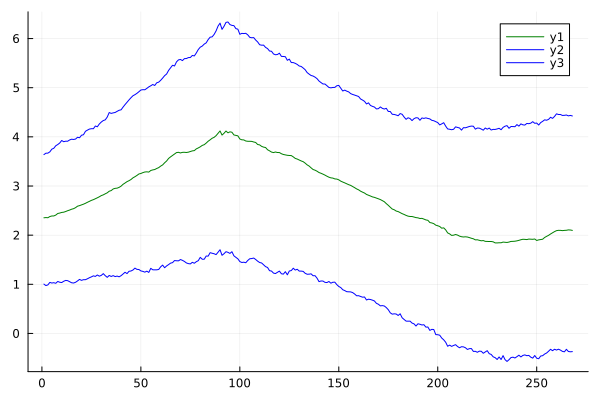

In [43]:
st = 1
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

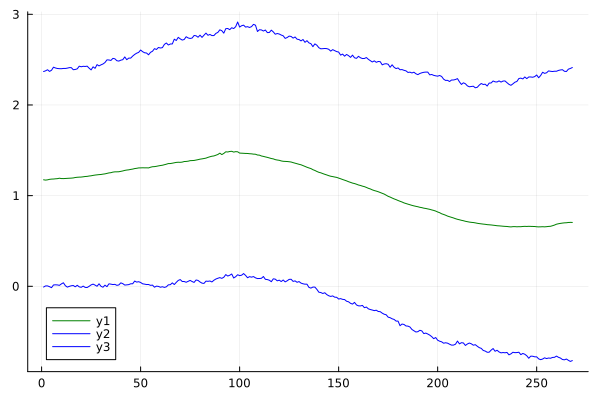

In [44]:
st = 2
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

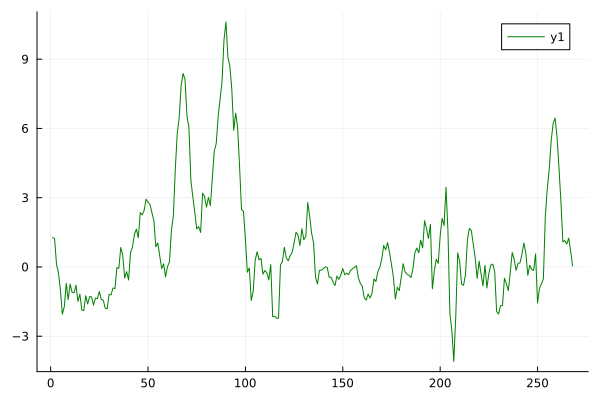

In [45]:
st=1
plot(cycle_states_mean[:,st], color="green" )


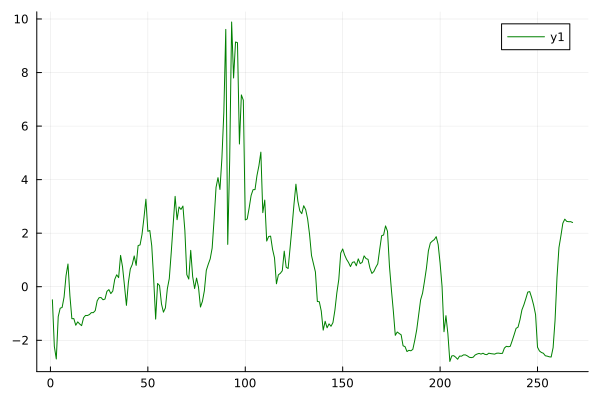

In [46]:
st = 2
plot(cycle_states_mean[:,st], color="green" )

In [47]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Στ[1]    0.0114    0.0018    0.0001    968.9730   1518.6028    1.0011   ⋯
       Στ[2]    0.0002    0.0006    0.0000   1087.1605   1351.7170    1.0019   ⋯
       Στ[3]    0.0002    0.0006    0.0000   1087.1605   1351.7170    1.0019   ⋯
       Στ[4]    0.0027    0.0004    0.0000   1141.2963   1577.8733    1.0034   ⋯
                                                                1 column omitted


In [60]:
display(.0114^.5 * 2) 
display(.0027^.5 * 2)

0.21354156504062624

0.10392304845413264

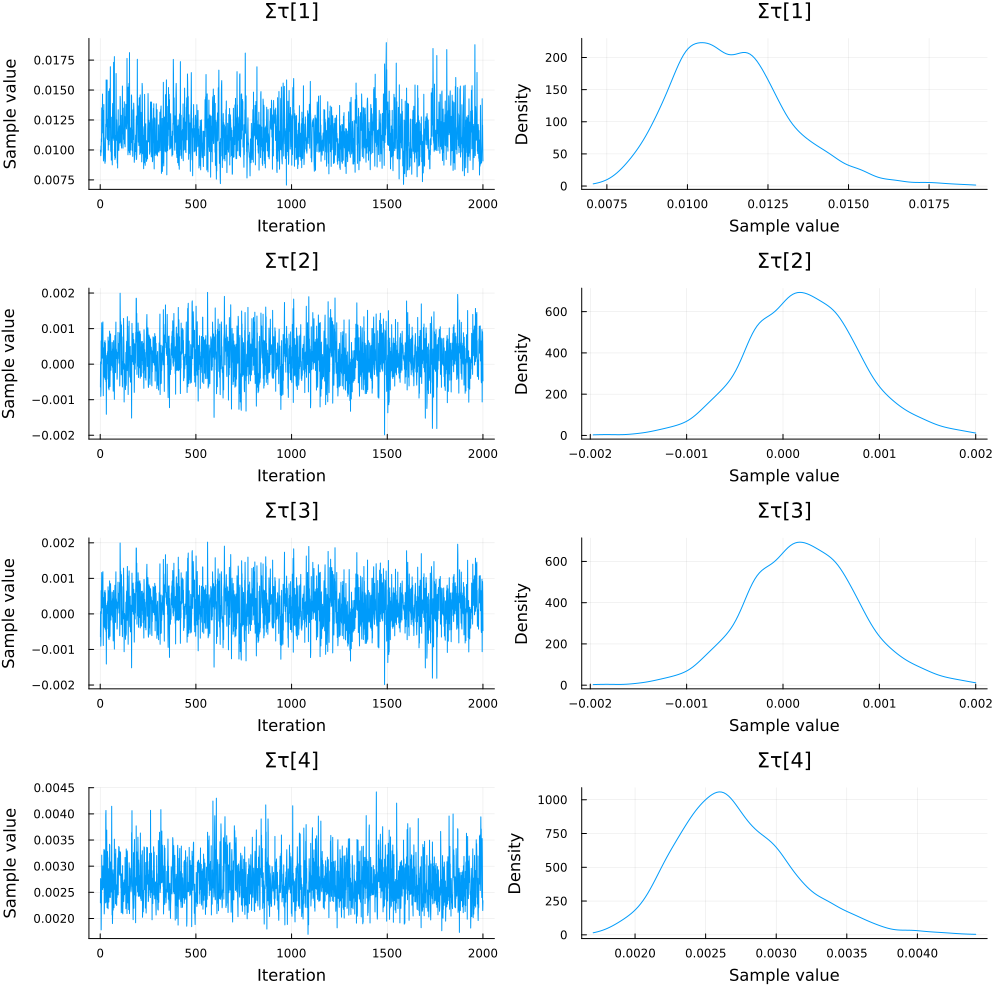

In [48]:
plot(trend_covariance_samples)

In [49]:
summarystats(betas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          β1    0.9211    0.0296    0.0007   1820.7816   1962.0911    1.0002   ⋯
          β2    0.0082    0.0322    0.0008   1556.4332   1850.6777    1.0002   ⋯
          β3    0.0681    0.0293    0.0007   1939.4391   1796.7470    0.9997   ⋯
          β4    0.8738    0.0357    0.0008   1933.1471   1857.4766    0.9995   ⋯
                                                                1 column omitted


In [50]:
summarystats(sigmas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Σc[1]    0.9128    0.0804    0.0018   1974.9739   2046.6150    0.9999   ⋯
       Σc[2]    0.1915    0.0576    0.0013   1997.8917   1863.0846    1.0008   ⋯
       Σc[3]    0.1915    0.0576    0.0013   1997.8917   1863.0846    1.0008   ⋯
       Σc[4]    0.9472    0.0831    0.0020   1757.4695   1931.4944    1.0056   ⋯
                                                                1 column omitted


In [ ]:
Σc = mean(sigmas_samples).nt.mean
Σc = reshape(Σc, 2, 2)
display(Σc)

β = mean(betas_samples).nt.mean
β = reshape(β, 2, 2)
display(β)

Στ = mean(trend_covariance_samples).nt.mean
Στ = reshape(Στ, 2, 2)
display(Στ)

2×2 Matrix{Float64}:
 0.912786  0.191494
 0.191494  0.947244

2×2 Matrix{Float64}:
 0.921147    0.0681316
 0.00824034  0.873819

2×2 Matrix{Float64}:
 0.0113781    0.000211674
 0.000211674  0.00271115

In [56]:
(.9128 * 4)^.5

1.9108113459993898

In [57]:
(.9472 * 4)^.5

1.9464840096954303